
# Agent + Graph Memory (FAQ) — Explorer

Notebook uruchamia agenta na Twoim FAQ, pozwala **podejrzeć graf** (węzły + krawędzie) i **narysować** jego podzbiór.



## 0) Wymagane katalogi i pliki

Uruchom ten notebook **z katalogu repozytorium**, gdzie masz struktury:
- `tools/faq_generator/parser.py`
- `data/banking_faq_30plus.txt`

> Jeżeli masz folder `adapter/` zamiast `adapters/`, notebook obsłuży obie wersje.


In [1]:

# (Opcjonalnie) doinstaluj brakujące paczki
import sys, subprocess

def ensure(pkg: str):
    try:
        __import__(pkg)
    except Exception:
        print(f"Installing {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

for p in ["numpy", "networkx", "matplotlib", "pydantic"]:
    ensure(p)

print("✅ Environment ready")


Installing networkx...
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
Using cached networkx-3.5-py3-none-any.whl (2.0 MB)
Installing matplotlib...
  Using cached matplotlib-3.10.7-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (112 kB)
  Using cached kiwisolver-1.4.9-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.7-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (8.7 MB)
Using cached contourpy-1.3.3-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (355 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttool


## 1) Wykrycie katalogu repo


In [3]:

from pathlib import Path
import sys

# Przyjmij bieżący katalog, ale sprawdź, czy są wymagane pliki
REPO_ROOT = Path.cwd()

def has_required_paths(root: Path) -> bool:
    return (root / "tools" / "faq_generator" / "parser.py").exists() and            (root / "data" / "banking_faq_30plus.txt").exists()

# Spróbuj również w podkatalogach (na wypadek dodatkowego poziomu)
candidates = [REPO_ROOT] + [p for p in REPO_ROOT.iterdir() if p.is_dir()]

chosen = None
for cand in candidates:
    if has_required_paths(cand):
        chosen = cand.resolve()
        break

if chosen is None:
    raise FileNotFoundError(
        "Nie znaleziono repo z `tools/faq_generator/parser.py` oraz `data/banking_faq_30plus.txt`."
        "Uruchom notebook w katalogu repo lub ustaw REPO_ROOT ręcznie.")

REPO_ROOT = chosen
if str(REPO_ROOT) not in sys.path:
    sys.path.append(str(REPO_ROOT))

REPO_ROOT


PosixPath('/home/jupyter/olga_zydziak/version_beta/Folder/chatbot-simple')


## 2) Import modułów i zbudowanie agenta


In [4]:

from pathlib import Path
import time

# Upewnij się, że agent.py istnieje w repo. Jeżeli nie, zapiszemy wersję referencyjną z tego notebooka.
AGENT_PATH = REPO_ROOT / "agent.py"

EMBEDDED_AGENT_SRC = r"""""" + '''# agent.py
# Minimal memory-aware agent for Banking FAQ backed by a graph memory (MVP).
# No __main__ here — run it from a notebook or another script.
from __future__ import annotations

import time
import re
from typing import Protocol, List

from graph_mem import GraphMem, Fact


class Model(Protocol):
    \"""Minimal protocol for pluggable text generation models.\"""
    def generate(self, prompt: str) -> str: ...


class HeuristicModel:
    \"""
    Extremely lightweight "generator":
    - Looks for the first line starting with "A:" inside the provided FACT blocks.
    - If nothing is found, returns the first non-empty line of the first FACT.
    - Otherwise returns a safe fallback.
    \"""
    _fact_block_re = re.compile(r"### FACT\\n(.*?)(?=\\n### FACT|\\Z)", flags=re.S | re.M)

    def generate(self, prompt: str) -> str:
        facts = self._fact_block_re.findall(prompt) or []

        # 1) Try to extract 'A:' from top-ranked facts
        for fact in facts:
            m = re.search(r"^A:\\s*(.+)$", fact, flags=re.M)
            if m:
                return m.group(1).strip()

        # 2) Otherwise, best-effort: return first informative line from first fact
        if facts:
            lines = [ln.strip() for ln in facts[0].splitlines() if ln.strip()]
            # Prefer second line (often 'Q:' is first), else the first line
            if len(lines) >= 2:
                return lines[1]
            return lines[0]

        # 3) Fallback
        return "Nie wiem na podstawie dostarczonych faktów."
    

class MemoryAwareAgent:
    \"""
    Agent that:
    - retrieves a context from GraphMem,
    - builds a prompt,
    - lets a pluggable Model generate an answer,
    - stores the dialogue into memory for continuity.
    \"""
    def __init__(self, memory: GraphMem, model: Model | None = None):
        self.memory = memory
        self.model = model or HeuristicModel()

    def build_prompt(self, user_msg: str, context: List[Fact]) -> str:
        context_text = "\\n\\n".join(f"### FACT\\n{f.text}" for f in context)
        return (
            "You are a banking FAQ assistant. Use ONLY the provided facts to answer.\\n"
            "If the answer is not covered, say you don't know.\\n\\n"
            f"{context_text}\\n\\n"
            f"User: {user_msg}\\n"
            "Answer: "  # trailing space avoids returning bare 'Answer:' with trivial models
        )

    def reply(self, user_msg: str, top_k: int = 6) -> str:
        now = time.time()
        ctx = self.memory.retrieve(user_msg, now_ts=now, k=top_k)
        prompt = self.build_prompt(user_msg, ctx)
        answer = self.model.generate(prompt)
        # persist the interaction to memory for future rounds
        self.memory.add(f"USER: {user_msg}", ts=now)
        self.memory.add(f"ASSISTANT: {answer}", ts=now)
        return answer


def build_agent_from_faq(
    faq_path: str,
    tau: float = 0.35,
    k: int = 5,
    alpha: float = 0.7,
) -> MemoryAwareAgent:
    \"""
    Convenience helper:
    - creates GraphMem with given params,
    - ingests the FAQ file using your project's FAQParser adapter,
    - returns a ready-to-use MemoryAwareAgent.

    Supports both 'adapters' and 'adapter' module names.
    \"""
    gm = GraphMem(tau=tau, k=k, alpha=alpha)

    # Import ingest adapter lazily to support both folder names
    ingest = None
    try:
        from adapters import faq_ingest_adapter as ingest  # type: ignore
    except Exception:
        try:
            from adapter import faq_ingest_adapter as ingest  # type: ignore
        except Exception as e:
            raise ImportError(
                "Nie można zaimportować adaptera FAQ. Upewnij się, że masz "
                "'adapters/faq_ingest_adapter.py' lub 'adapter/faq_ingest_adapter.py'."
            ) from e

    ingest.ingest_faq_to_graph(faq_path, gm)
    return MemoryAwareAgent(gm)
''' + r""""""  # wstawiony poniżej

if not AGENT_PATH.exists():
    print("⚠️  Nie znaleziono agent.py — tworzę referencyjny plik w repo.")
    AGENT_PATH.write_text(EMBEDDED_AGENT_SRC, encoding="utf-8")

from agent import build_agent_from_faq  # importuje z repo
faq_file = REPO_ROOT / "data" / "banking_faq_30plus.txt"
agent = build_agent_from_faq(str(faq_file))

# Mały sanity-check
gm = agent.memory
print("Załadowano faktów:", len(gm.facts))
assert len(gm.facts) > 0, "Brak faktów — sprawdź ścieżkę do data/banking_faq_30plus.txt"


Załadowano faktów: 32



## 3) Q&A demo (retrieve + heurystyczna odpowiedź)


In [5]:

def ask(q: str, top_k: int = 6):
    print("\nUser:", q)
    a = agent.reply(q, top_k=top_k)
    print("Agent:", a)

ask("Jak zgłosić spór do transakcji kartą?")
ask("Jakie dokumenty potrzebne do chargeback?")
ask("Czy mogę zmienić limit transakcji?")



User: Jak zgłosić spór do transakcji kartą?
Agent: ALIASES: Jak uruchomić chargeback, Reklamacja transakcji kartą, Zgłoszenie sporu

User: Jakie dokumenty potrzebne do chargeback?
Agent: ALIASES: Dokumenty do reklamacji, Co dołączyć do chargeback

User: Czy mogę zmienić limit transakcji?
Agent: ALIASES: Zaświadczenie bankowe, Potwierdzenie konta



## 4) Podgląd grafu — węzły i krawędzie
Poniżej wypiszemy kilka węzłów i ich sąsiadów (krawędzie przechowujemy jako **lista sąsiedztwa**).


In [6]:

# Statystyki grafu
num_nodes = len(gm.facts)
num_edges = sum(len(f.neigh) for f in gm.facts)  # kierunkowe
print(f"Węzły: {num_nodes}, krawędzie (kierunkowe): {num_edges}")

# Pokaż pierwsze N węzłów i ich sąsiadów
N = 5
for i in range(min(N, num_nodes)):
    f = gm.facts[i]
    head = (f.text.splitlines()[0] if f.text else "")[:140]
    print(f"\n[{i}] {head}")
    for (j, w) in f.neigh[:8]:
        h2 = (gm.facts[j].text.splitlines()[0] if gm.facts[j].text else "")[:100]
        print(f"   -> {j}  sim={w:.3f}  | {h2}")


Węzły: 38, krawędzie (kierunkowe): 175

[0] [CATEGORY] chargeback

[1] [CATEGORY] chargeback
   -> 0  sim=0.907  | [CATEGORY] chargeback

[2] [CATEGORY] chargeback
   -> 1  sim=0.828  | [CATEGORY] chargeback
   -> 0  sim=0.787  | [CATEGORY] chargeback

[3] [CATEGORY] chargeback
   -> 1  sim=0.818  | [CATEGORY] chargeback
   -> 2  sim=0.774  | [CATEGORY] chargeback
   -> 0  sim=0.772  | [CATEGORY] chargeback

[4] [CATEGORY] card
   -> 1  sim=0.745  | [CATEGORY] chargeback
   -> 3  sim=0.738  | [CATEGORY] chargeback
   -> 2  sim=0.723  | [CATEGORY] chargeback
   -> 0  sim=0.705  | [CATEGORY] chargeback



## 5) Rysowanie grafu (NetworkX + Matplotlib)

> Dla bardzo dużych grafów losujemy podzbiór węzłów, żeby rysunek był czytelny.


Rysuję graf o 38 węzłach i 175 krawędziach...


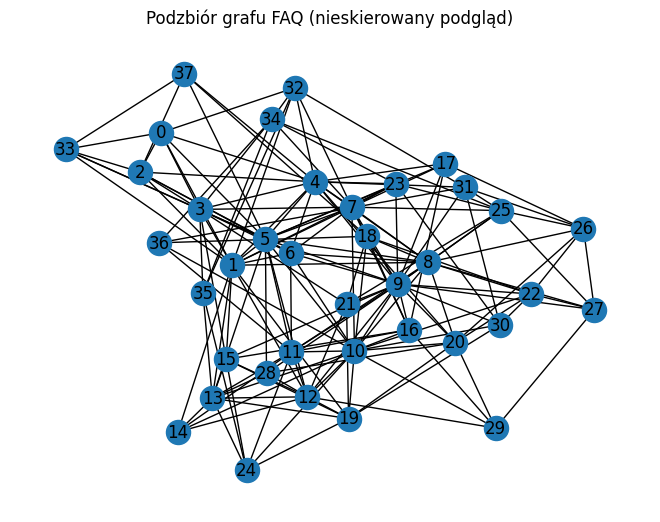

In [7]:

import random
import networkx as nx
import matplotlib.pyplot as plt

# Zbuduj graf (nieskierowany dla czytelności)
G = nx.Graph()
for i, f in enumerate(gm.facts):
    G.add_node(i)
    for j, w in f.neigh:
        G.add_edge(i, j, weight=float(w))

# Jeśli jest bardzo duży — weź próbkę
MAX_NODES = 120
if G.number_of_nodes() > MAX_NODES:
    nodes = list(G.nodes())
    sample = set(random.sample(nodes, MAX_NODES))
    H = G.subgraph(sample).copy()
else:
    H = G

print(f"Rysuję graf o {H.number_of_nodes()} węzłach i {H.number_of_edges()} krawędziach...")

pos = nx.spring_layout(H, seed=42)
plt.figure()
nx.draw(H, pos, with_labels=True)  # bez określania kolorów/style
plt.title("Podzbiór grafu FAQ (nieskierowany podgląd)")
plt.show()



## 6) (Opcjonalnie) Zapis/odczyt grafu do JSON


In [12]:

import json

def save_graph_json(gm, path="graph_dump.json"):
    data = {
        "nodes": [{"id": i, "ts": f.ts, "text": f.text} for i, f in enumerate(gm.facts)],
        "edges": [{"src": i, "dst": j, "w": float(w)}
                  for i, f in enumerate(gm.facts) for (j, w) in f.neigh],
    }
    with open(path, "w", encoding="utf-8") as fp:
        json.dump(data, fp, ensure_ascii=False, indent=2)
    print(f"Zapisano do {path}")

def load_graph_json(path="graph_dump.json"):
    from graph_mem import GraphMem, Fact, _hash_embed
    with open(path, "r", encoding="utf-8") as fp:
        data = json.load(fp)
    gm2 = GraphMem()
    for n in data["nodes"]:
        vec = _hash_embed(n["text"])
        gm2.facts.append(Fact(text=n["text"], ts=n["ts"], vec=vec, neigh=[]))
    for e in data["edges"]:
        gm2.facts[e["src"]].neigh.append((e["dst"], float(e["w"])))
    return gm2

# Przykład użycia:
save_graph_json(gm, "graph_dump.json")
gm_clone = load_graph_json("graph_dump.json")
print("Skopiowano węzłów:", len(gm_clone.facts))


Zapisano do graph_dump.json
Skopiowano węzłów: 38
